# Tonti Diagram CFD Demo
This notebook demonstrates an example of the current interface for the definition and execution of Tonti diagrams. The fluid dynamics presented here are approximate, yet demonstrate how multiple physics can be defined and simulated.

In [1]:
#== Import required libraries ==#
using Catlab.Graphs
using Catlab.Graphics
using Catlab.CategoricalAlgebra
using CombinatorialSpaces
using Distributions
using CairoMakie
using DifferentialEquations
using AlgebraicDynamics.TontiDiagrams

In [2]:
# helper function for setting initial conditions
function gen_form(s::EmbeddedDeltaSet2D, f::Function)
  map(f, point(s))
end

gen_form (generic function with 1 method)

## Import a mesh for the physics
We begin by importing a mesh which the DEC operators will be defined on. Our goal is to have application of a physics to a mesh be the last step (after defining the physics in a Tonti diagram).

In [3]:
s = EmbeddedDeltaSet2D("../examples/meshes/naca0012_8.stl");
sp = Space(s)
sd = sp.sd;
figure, axis, ob = wireframe(s)
axis.aspect = AxisAspect(100.0/30.0)
figure

## Define boundaries
Currently boundaries are obtained through calculating all boundary edges, then filtering by location for appropriate specific boundaries. This will be replaced with a connected components algorithm, which can present each individual boundary automatically.

In [4]:
# Get boundary masks for BCs
boundary_e = findall(x -> x != 0, boundary(Val{2},s) * fill(1,ntriangles(s)))
boundary_v = unique(vcat(s[boundary_e,:src],s[boundary_e,:tgt]))

obj_v = filter(x->all((-15.0,-10.0,0.0) .<= s[x,:point] .<= (15.0,10.0,0.0)), boundary_v)
obj_e = unique(vcat(incident(s, obj_v,:src)..., incident(s, obj_v,:tgt)...));

left_v = filter(x->all((-50,-15.0,0.0) .<= s[x,:point] .<= (-50.0,15.0,0.0)), boundary_v)
left_e = unique(vcat(incident(s, left_v,:src)..., incident(s, left_v,:tgt)...));

right_v = filter(x->all((50,-15.0,0.0) .<= s[x,:point] .<= (50.0,15.0,0.0)), boundary_v)
right_e = unique(vcat(incident(s, right_v,:src)..., incident(s, right_v,:tgt)...));
right_2v = unique(vcat(s[right_e,:src],s[right_e,:tgt]))

top_v = filter(x->all((-50,15.0,0.0) .<= s[x,:point] .<= (50.0,15.0,0.0)), boundary_v)
top_e = unique(vcat(incident(s, top_v,:src)..., incident(s, top_v,:tgt)...));

bot_v = filter(x->all((-50,-15.0,0.0) .<= s[x,:point] .<= (50.0,-15.0,0.0)), boundary_v)
bot_e = unique(vcat(incident(s, bot_v,:src)..., incident(s, bot_v,:tgt)...));

center_v = filter(x->all((-15.0,-10.0,0.0) .<= s[x,:point] .<= (15.0,10.0,0.0)), 1:nv(s));

## Initialize the Tonti diagram
We begin by initializing the ACSet which will store our Tonti diagram.

In [5]:
td = TontiDiagram();

## Define the diffusion/advection physics
We will have a marker dye to show the flow of the system, so we first define the physics of the diffusion/advection of this dye.

In [6]:
# Define variables along with their dimensionality (var_name, dimensionality, complex (primal vs. dual))
add_variables!(td, (:C,0,true),(:ϕ,1,false),(:∑ϕ,2,false), (:∂C,0,true),
                   (:v,1,true), (:Cv,1,true))

# Add spatial and temporal derivative relationships
add_derivatives!(td, sp, :ϕ=>:∑ϕ)
add_time_dep!(td, :∂C, :C)

# We can add complex operators like the Laplacian for diffusive relationships
add_laplacian!(td, sp, :C, :∂C; coef=0.1)

# Currently the Lie derivative is defined "by hand", but this will be moved to the Tonti diagram library
add_transition!(td, [:C, :v], (Cv,C,v)->(Cv .= ∧(Tuple{0,1},sd,C,v)) ,[:Cv])
add_transition!(td, [:Cv], (x,y)->(x.=sp.hodge[1,2]*y) ,[:ϕ]);
add_transition!(td, [:∑ϕ], (x,y)->(x.=sp.hodge[2,3]*y) ,[:∂C])

# Boundary conditions restrict the left and right edges
add_bc!(td, :∂C, ∂C->(∂C[vcat(left_v,right_2v)].=0))

1

## Define the flow physics
In this case, we have two flow field variables, `v` and `u`. `v` is defined on the primal complex and called the tangential velocity, while `u` is defined on the dual complex and called the normal velocity.

In [7]:
# Flow
add_variables!(td, (:u,1,false),(:∂u,1,false), (:∂v,1,true))
add_time_dep!(td, :∂v, :v)

# Lie derivative defined here for the "flow of the flow"
add_transition!(td, [:v], (u,v)->(u .= sp.hodge[1,2]*v) ,[:u])
add_transition!(td, [:u,:v],
  (∂u,u,v)->( (sp.hodge[1,2]*∧(Tuple{1,0},sd,v,sp.hodge[2,3]*sp.boundary[2,2]*u) .+ sp.boundary[2,1]*sp.hodge[1,3]*∧(Tuple{1,1},sd,v,sp.hodge[2,2]*u)))
  ,[:∂u])
add_transition!(td, [:∂u], (∂v, ∂u)->(∂v .= sp.hodge[2,2]*∂u) ,[:∂v])
lap_arr = sp.boundary[1,1]*sp.hodge[2,3]*sp.boundary[2,2]*sp.hodge[1,2] + sp.hodge[2,2]*sp.boundary[2,1]*sp.hodge[1,3]*sp.boundary[1,2]

# This diffusive relationship adds viscosity to the system
add_laplacian!(td, sp, :v, :∂v; coef = 1)

# constant in-flow and out-flow, and no-slip on the top, bottom, and airfoil
add_bc!(td, :∂v, v->(v[vcat(left_e,right_e)].=0))
add_bc!(td, :v, v->(v[vcat(top_e,bot_e, obj_e)].=0));

## Define the pressure physics
Here we use a very basic definition of pressure (using the ideal gas law) to assist with continuity of the velocity.

In [8]:
# Pressure
add_variables!(td, (:p,0,true),(:∂p,0,true))

add_time_dep!(td, :∂p, :p)
pressure_op = 30 * sp.hodge[2,3] * sp.boundary[2,2]
add_transition!(td, [:u],  (∂p,u)->(∂p .= pressure_op*u), [:∂p])
depress_op = -1 .* sp.hodge[1,2]*sp.boundary[1,1]
add_transition!(td, [:p],  (∂u,p)->(∂u .= depress_op*p), [:∂u]);

## Generate the simulator
This vectorfield object can be passed to DifferentialEquations.jl to be solved

In [9]:
data, sim = vectorfield(td, sp);
data

Dict{Symbol,Tuple{Int64,Int64}} with 3 entries:
  :p => (30160, 37837)
  :v => (7679, 30159)
  :C => (1, 7678)

## Define our initial conditions

In [10]:
c_range = range(data[:C]...,step=1)
v_range = range(data[:v]...,step=1)
p_range = range(data[:p]...,step=1)
u = zeros(Float64,maximum(last.(values(data))))
c = gen_form(s, x->x[1] < -25.0 ? cos(x[2] * 2π / 5.0) + 1 : 0.0)
p = gen_form(s, x->0.0);

In [11]:
velocity(x) = begin
  amp = 2.0
  amp * Point{3,Float64}(-1,0,0)
end
v = ♭(sd, DualVectorField(velocity.(sd[triangle_center(sd),:dual_point])));

In [12]:
u[c_range] .= c
u[v_range] .= v
u[p_range] .= p;

## Solve the system

In [13]:
tspan=(0.0,25.0)
prob = ODEProblem(sim, u, tspan)
sol = solve(prob, Tsit5());

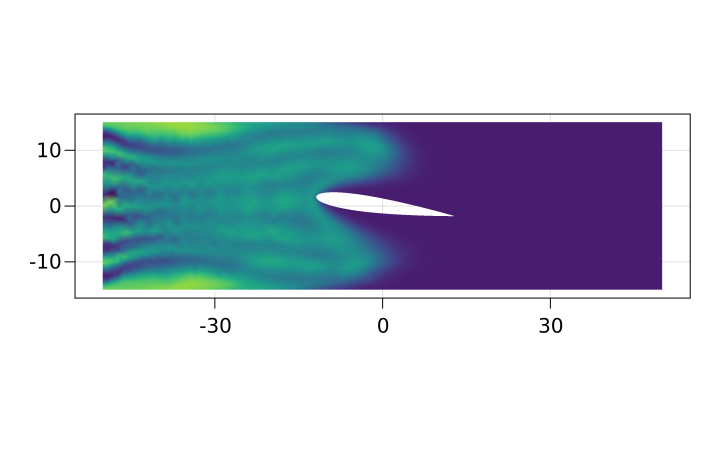

In [14]:
times = range(0,tspan[2], length=150)
colors = [sol(t)[c_range] for t in times]
figure, axis, scatter_thing = mesh(s, color=colors[75],
                                   colorrange=(minimum(vcat(colors...)),
                                               maximum(vcat(colors...))))
axis.aspect = AxisAspect(100.0/30.0)
figure

In [15]:
framerate = 30
record(figure, "flow_conc.gif", collect(1:length(collect(times))); framerate = framerate) do i
  scatter_thing.color = colors[i]
end

"flow_conc.gif"

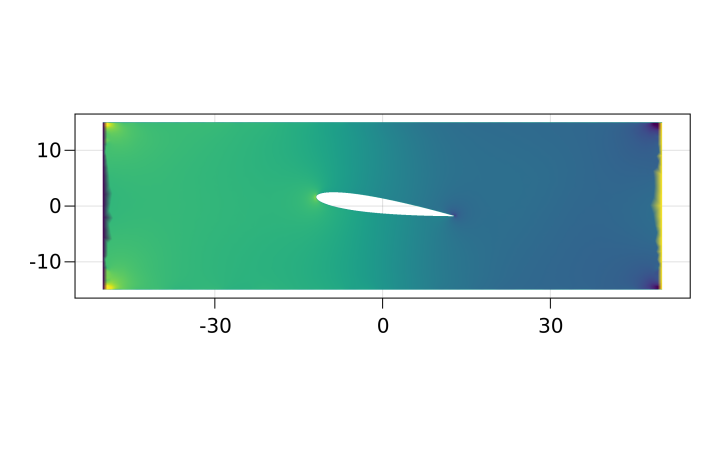

In [16]:
times = range(0,tspan[2], length=150)
colors = [sol(t)[p_range] for t in times]

color_range = [sol(t)[p_range][center_v] for t in times]
figure, axis, scatter_thing = mesh(s, color=colors[150],
                                   colorrange=(minimum(vcat(color_range...)),
                                               maximum(vcat(color_range...))))
axis.aspect = AxisAspect(100.0/30.0)
figure

In [17]:

framerate = 30

record(figure, "flow_press.gif", collect(1:length(collect(times))); framerate = framerate) do i
  scatter_thing.color = colors[i]
end

"flow_press.gif"